In [677]:
#import major libraries to manipulate data 
import pandas as pd
import numpy as np
import xlrd

#import datetime libraries
from datetime import datetime, date
from dateutil import relativedelta


# import major libraries to plot data
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

#allow inline charts visualizations
%matplotlib inline

In [2]:
#load excel files into a dataframe
sales_data = pd.read_excel('/Users/joaosoares/PycharmProjects/untitled/sales_data.xlsx')

In [3]:
prices = pd.read_excel('/Users/joaosoares/PycharmProjects/untitled/prices.xlsx')

# Question 1

The business wants to know the revenue over time for each market and each flavor. Prepare a set of meaningful and readable plots.

In [6]:
#merge sales data and price to form a unique table
customer_sales = pd.merge(prices, sales_data, how='inner', on=['flavor','market'])

In [8]:
#grouping data by market and flavor and using sum as aggregate function
market_flavor_grouping = customer_sales.drop(columns='customer_id').groupby(by=['market','flavor'])

In [9]:
market_flavor_revenue = market_flavor_grouping.sum()

In [10]:
market_flavor_revenue.reset_index(inplace=True)

Text(0.5,0.98,'revenue over time per market and flavor')

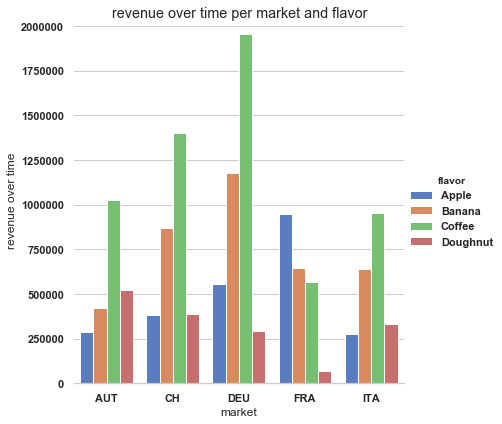

In [694]:
# Draw a nested barplot to show revenue over time for market and flavor
sns.set(style="whitegrid")
g = sns.catplot(x="market", y="price", hue="flavor", data=market_flavor_revenue,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("revenue over time")
g.fig.suptitle("revenue over time per market and flavor")

# Question 2

The business wants to understand how much money we make per customer in each market on average.

In [702]:
#grouping data by market and flavor and using mean as aggregate function
flavor_avg_market_split = customer_sales.drop(columns='customer_id').groupby(by=['market','flavor']).mean()

In [703]:
#define function to transform default percentage values into nominal values
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '({v:d})'.format(p=pct,v=val)
    return my_autopct

Text(0.5,0.95,'Customer Lifetime Revenue (CLR)\nAverage Revenue in Euros')

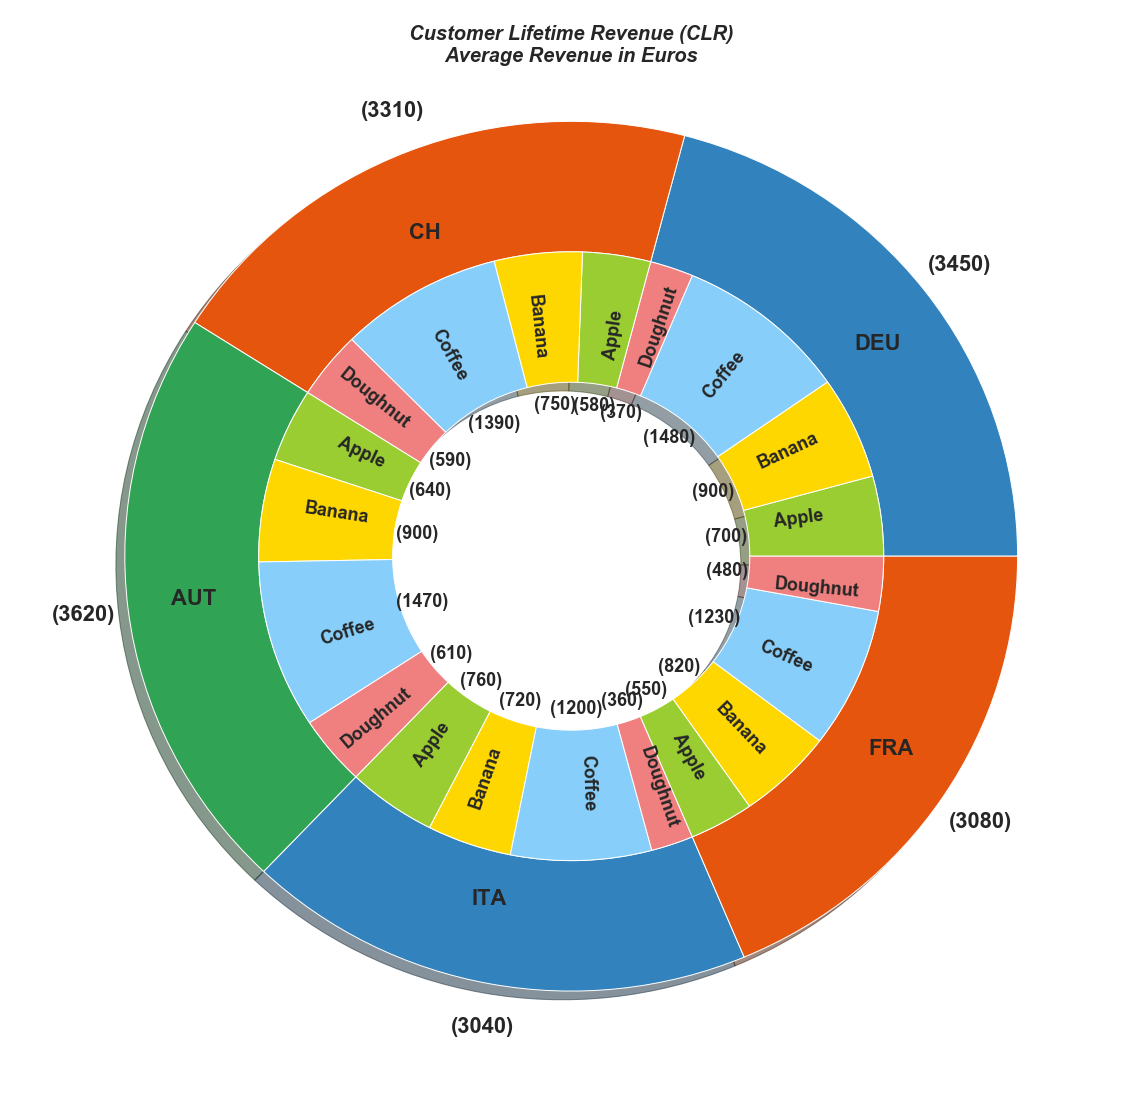

In [708]:
#plot nested pie chart with customized colors, titles and labels

fig, ax = plt.subplots(figsize=(20,20))
labels1 = list(set(flavor_avg_market_split.reset_index().market))
labels2 = list(flavor_avg_market_split.reset_index().flavor)
size = 0.3
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))
ax.pie(flavor_avg_market_split.sum(level='market',axis=0).price, radius=1,textprops={'fontsize': 22}, 
       shadow=True, labels=labels1, labeldistance=0.8, colors=outer_colors, wedgeprops=dict(width=size, edgecolor='w'),
       autopct=make_autopct(flavor_avg_market_split.sum(level='market',axis=0).price), pctdistance=1.1)
ax.pie(flavor_avg_market_split.reset_index().price, radius=1-size, textprops={'fontsize': 18}, labels=labels2, 
       shadow=True, rotatelabels=0.5, labeldistance=0.65, colors=colors, wedgeprops=dict(width=size, edgecolor='w'), 
       autopct=make_autopct(flavor_avg_market_split.reset_index().price), pctdistance=0.5)
ax.set_title('''Customer Lifetime Revenue (CLR)
Average Revenue in Euros''', fontsize=20, fontstyle='oblique', fontweight='bold', position=(0.5,0.95))

# Question 3 

### Flavor preferences in first vs following purchase

The business suspects that customers' first purchases follow different patterns than following purchases.

Create plots that show for each country the customers' flavor preferences for their first purchase versus their preferences for following purchases.
● Note that we are not interested in absolute sales or revenue, but in preference of flavor by country!
● We want to see "first" versus "following" purchase, and not "first" versus "second", "third", etc! “Following” means any purchase that is not the first one.

In [25]:
df = sales_data.drop(columns=['flavor','date']).sort_values(['market','customer_id']).reset_index(drop=True)

In [26]:
df.drop_duplicates(subset='customer_id',inplace=True)

In [27]:
df = df.merge(sales_data,how='inner',on=['customer_id','market'])

In [28]:
df = pd.pivot_table(df,index=['customer_id','market'], values='flavor',aggfunc=lambda x: ' '.join(x))

In [29]:
df = df.join(df['flavor'].str.split(' ', expand=True).add_prefix('n').fillna(np.nan))

In [30]:
df.drop(columns='flavor', inplace=True)

In [31]:
df = df.reset_index().melt(['market','customer_id','n0'], value_vars=['n1','n2','n3','n4','n5']).sort_values(['market','customer_id']).dropna()

In [32]:
df.drop(columns='variable', inplace=True)

In [33]:
df.columns = ['market','customer_id','first','following']

In [34]:
consumer_habits = df.groupby(by=['market','first','following'],sort=True).count()

In [35]:
consumer_habits.columns = ['count']

In [36]:
consumer_habits.reset_index(inplace=True)

In [748]:
#defining variables to be used in the for loop
markets = ['DEU','ITA','CH','FRA','AUT']
flavors = ['Apple','Banana','Coffee','Doughnut']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
fig = plt.figure(figsize=(300,70))

#for loop to generate all 5 markets plots
for n in range(5):
    plt.subplot(1, 5, n + 1, polar=False)

    # Values of each group
    bars1 = consumer_habits['count'][(consumer_habits['market'] == markets[n]) & (consumer_habits['first'] == flavors[0])]
    bars2 = consumer_habits['count'][(consumer_habits['market'] == markets[n]) & (consumer_habits['first'] == flavors[1])]
    bars3 = consumer_habits['count'][(consumer_habits['market'] == markets[n]) & (consumer_habits['first'] == flavors[2])]
    bars4 = consumer_habits['count'][(consumer_habits['market'] == markets[n]) & (consumer_habits['first'] == flavors[3])]

    # The position of the bars on the x-axis
    r = [0,1,2,3]

    # Names of group and bar width
    names = ['Apple','Banana','Coffee','Doughnut']
    barWidth = 1

    # Create apple bars
    plt.bar(r, bars1, color=colors[0], edgecolor='white', width=barWidth)
    # Create banana bars on top of apple bars
    plt.bar(r, bars2, bottom=bars1, color=colors[1], edgecolor='white', width=barWidth)
    # Create coffee bars (top)
    plt.bar(r, bars3, bottom=bars1, color=colors[2], edgecolor='white', width=barWidth)
    # Create doughnut bars (top)
    plt.bar(r, bars4, bottom=bars1, color=colors[3], edgecolor='white', width=barWidth)

    # labels and titles
    plt.xticks(r, names, fontweight='bold', fontsize=200, rotation=50)
    plt.yticks(np.array([0,100,200,300,400]),fontsize=200)
    plt.xlabel("first choice", fontsize=200)
    plt.ylabel("following choice(s)", labelpad=10, fontsize=250)
    plt.title(markets[n], fontweight='bold', fontsize=250)    

#enabling legend and defining overall title
plt.legend(flavors, prop={'size': 300}, loc=(1.2,0.5))
plt.suptitle("First Choices vs Follow Up Choices",x=0.5,y=1.1, fontsize=300, fontweight='demibold')
plt.tight_layout()

# Question 4

### First versus following in CLR

Create a plot like the one in task 2 showing average revenue by customer. This time, break it down by market (as in task 2) and by the contribution of the first purchase versus the contribution of all following purchases to the average revenue.

In [749]:
#create dataframe to manipulate data into first vs following
df1 = sales_data.merge(prices,on=['market','flavor'])

In [751]:
df1 = df1.sort_values(by=['customer_id','date'])

In [753]:
#drop date and flavor since we don't need them
df1 = df1.drop(columns=['date','flavor'])

In [755]:
#convert price into str in order to be able to concatenate prices from the same customer on one column
df1['price'] = df1['price'].apply(str)

In [757]:
#pivot prices into one column
df1 = pd.pivot_table(df1,index=['customer_id','market'], values='price',aggfunc=lambda x: ' '.join(x))

In [759]:
#split them into different columns
df1 = df1.join(df1['price'].str.split(' ', expand=True).add_prefix('n').fillna('0'))

In [761]:
#drop unnecessary price column after successful spliting 
df1.drop(columns='price', inplace=True)

In [772]:
df1.reset_index(inplace=True)

In [773]:
#convert again prices into integers
df1[['n0','n1','n2','n3','n4','n5']] = df1[['n0','n1','n2','n3','n4','n5']].apply(pd.to_numeric)

In [774]:
#sum all following choices revenues into one column
df1['following'] = df1.iloc[:, 3:].sum(1)

In [776]:
#and deleting the n temporary columns
df1.drop(columns=['customer_id','n1','n2','n3','n4','n5'], inplace=True)

In [777]:
df1 = df1.rename(columns={'n0': 'first choice'})

In [779]:
#grouping the data in order to plot it
g2 = df1.groupby('market').mean()
g2.reset_index(inplace=True)

In [781]:
#creating overall sum
overall = pd.Series(data={'market': 'OVERALL', 'first choice': g2['first choice'].mean(), 'following':g2['following'].mean()})

In [785]:
#appending overall to dataframe
g2 = g2.append(overall, ignore_index=True)

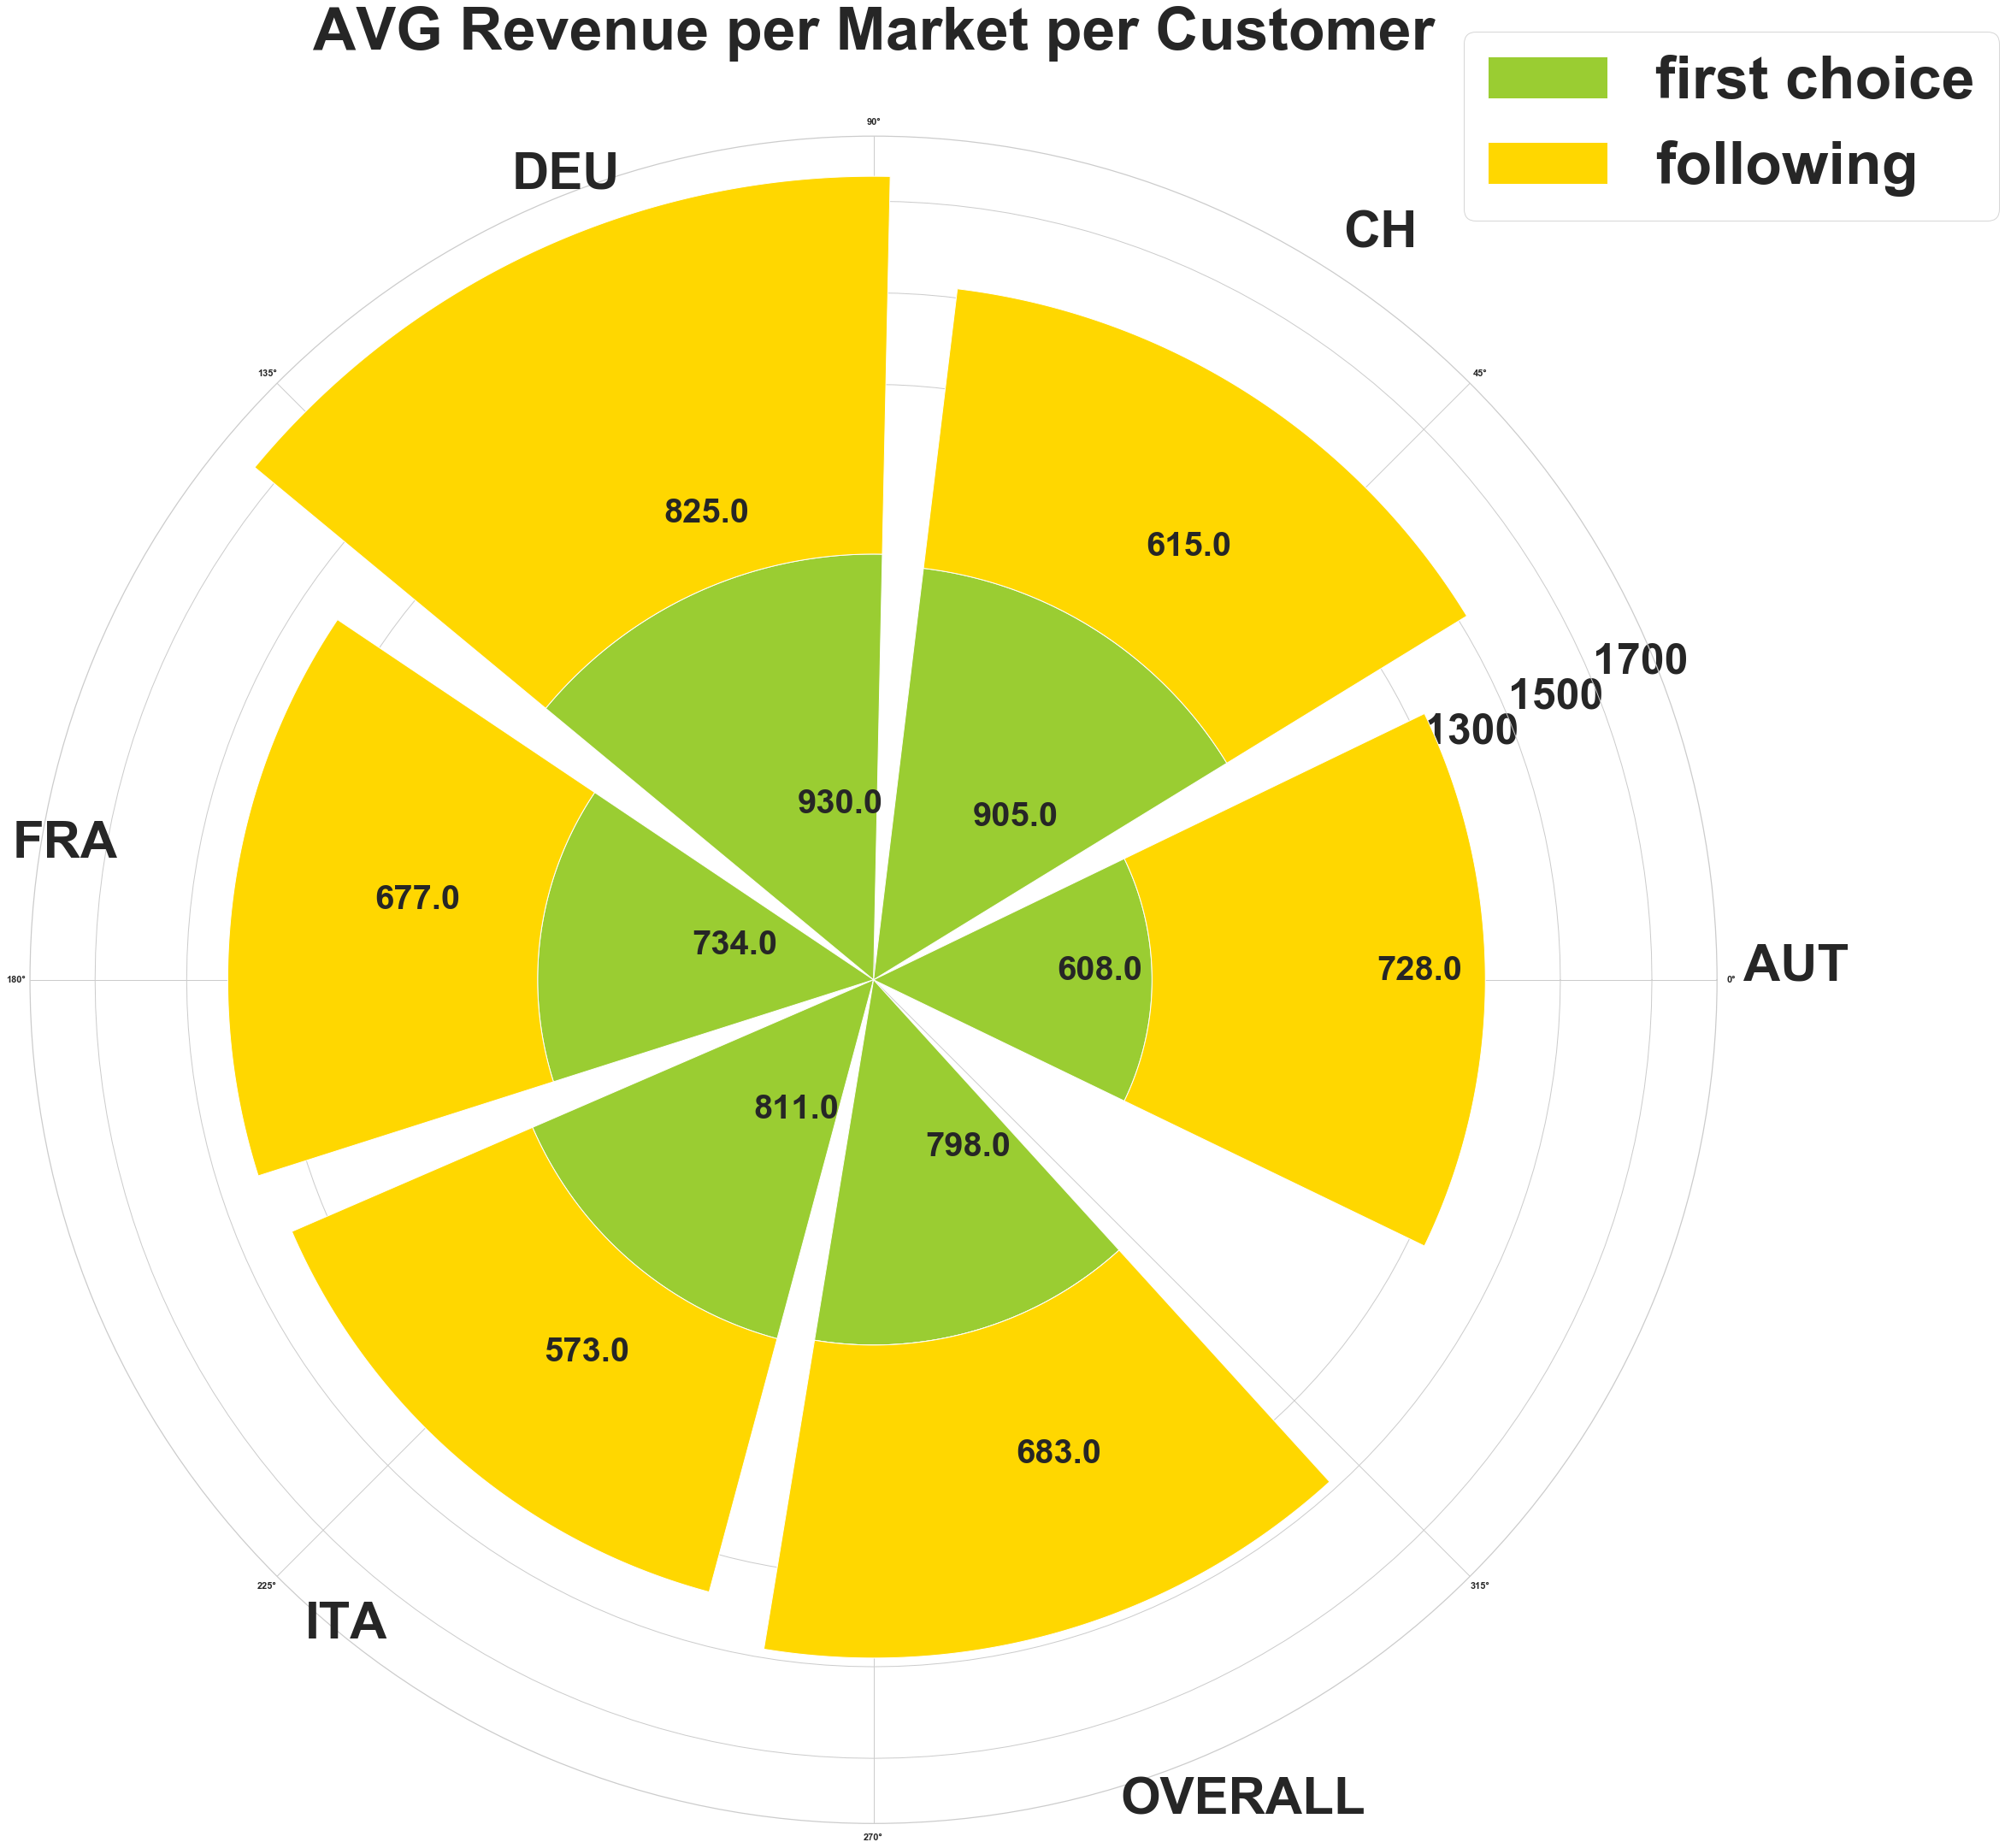

In [795]:
#set up variables to be used in for loop
markets = ['AUT','CH','DEU','FRA','ITA','OVERALL']
choice = ['first choice','following']
colors = ['yellowgreen', 'gold']
barWidth = 0.9
text_position = np.linspace(num=6, start=0, stop=5)

#create figure and polar subplot
fig = plt.figure(figsize=(80,30))
plt.subplot(111, polar=True)

#plot bars
for i in range(6):
    for n in [0,1]:
        if n == 1:
            plt.bar(i, g2[(g2['market'] == markets[i])][choice[n]], color=colors[n], edgecolor='white', width=barWidth, bottom=g2[(g2['market'] == markets[i])][choice[n-1]])
        if n == 0:
            plt.bar(i, g2[(g2['market'] == markets[i])][choice[n]], color=colors[n], edgecolor='white', width=barWidth)
#plot value labels
for i in range(6):
    plt.text(text_position[i], y=1100,s=str(g2[g2['market'] == markets[i]][choice[1]][i].round()), fontsize= 40)
    plt.text(text_position[i], y=400,s=str(g2[g2['market'] == markets[i]][choice[0]][i].round()), fontsize= 40)
    plt.text(text_position[i], y=1900,s=markets[i], fontsize= 60)

# enabling legend, setting ticks and defining overall title  
plt.yticks(np.array([1300,1500,1700]), fontsize=50, rotation=90)
plt.legend(choice, prop={'size': 70}, loc=(0.85,0.95))
plt.suptitle("AVG Revenue per Market per Customer",x=0.5,y=1, fontsize=70, fontweight='demibold')
plt.tight_layout()

# Question 5

### Transitions

We want to analyse how people switch between flavors. Visualise the probability of flavor transitions, i.e. of a customer buying flavor B after buying flavor A for all pairs of flavors. If a customer’s last purchase has occurred more than 6 months before the latest date in the dataset, we consider him as “churned”, and we record a transition from his last flavor to a special state called “churned”.

In [800]:
#perform a self join to get the transitions
df2 = sales_data.drop(columns='market').sort_values(by=['customer_id','date']).merge(sales_data, how='left', on='customer_id')

In [802]:
#eliminate duplicates from self join, keeping the last because it's the possible transition to churned
df2 = df2.drop_duplicates(subset=['customer_id','date_x','flavor_x'], keep='last')

In [804]:
# Create lists to store the data
churned = []
date_x = []
date_y = []
flavor_x = []
flavor_y = []

for x in df2['date_x']:
        date_x.append(x)
for y in df2['date_y']:
        date_y.append(y)
for z in df2['flavor_y']:
        flavor_y.append(z)
for a in df2['flavor_x']:
        flavor_x.append(a)

#add column and append transitions, or NaN in case of single transition without churn         
for i in range(len(df2)):
        if date_x[i] == date_y[i]:
            if relativedelta.relativedelta(date.today(), date_y[i].date()).months > 6:
                churned.append(flavor_x[i] + ' ' + 'churned')
            else:
                churned.append(None)
        else:
            churned.append(flavor_y[i] + ' ' + flavor_x[i])

#fill column from the list
df2['churned'] = churned

In [806]:
#pop the series the original dataframe
transitions = df2.pop('churned')

In [808]:
#make a count of the unique transitions
transitions_count = transitions.value_counts().sort_values(ascending=False)

In [827]:
#transform the count into a dataframe
df3 = transitions_count.to_frame('df3')

In [828]:
df3.reset_index(inplace=True)

In [829]:
#rename the columns in a different way
df3.columns = ['combinations','count']

In [830]:
#split the transitions and get the first and next transition on two different columns
df3 = df3.join(df3['combinations'].str.split(' ', expand=True).add_prefix('choice').fillna(np.nan))

In [832]:
df3.sort_values('combinations',inplace=True)

In [833]:
#get the sum of possible combitations of each flavor + churned
comb_sum = df3.groupby('choice0').sum()

In [835]:
comb_sum.reset_index(inplace=True)

In [664]:
#using these variables, create the possible combinations, get their respectives sum of possibilities and divide by 
#total sum combinations to obtain the probability for each pair
comb_var_no_churned = ['Apple', 'Banana', 'Coffee', 'Doughnut']
combinations_var = ['Apple', 'Banana', 'Coffee', 'Doughnut', 'churned']

for i in range(4):
    for x in range(5):
        df3.loc[df3[df3['combinations'] == comb_var_no_churned[i] + ' ' + combinations_var[x]].index.values.astype(int)[0], 'prob'] = df3.loc[df3[df3['combinations'] == comb_var_no_churned[i] + ' ' + combinations_var[x]].index.values.astype(int)[0],'count']/comb_sum.loc[comb_sum[comb_sum['choice0'] == comb_var_no_churned[i]].index.values.astype(int)[0],'count']

In [666]:
#pivot this probability data into a Markov chain Matrix
matrix = df3.pivot('choice0','choice1','prob')

In [843]:
#plot the matrix into a heatmap
matrix.iplot(zTitle='Probability',sharing='public', title='Flavor Transitions Probability Heatmap', kind='heatmap', colorscale='-rdBu')